# Проект для «Викишоп»

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Описание-проекта" data-toc-modified-id="Описание-проекта-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Описание проекта</a></span></li><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

## Описание проекта

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

In [39]:
#  Импорт необходимых библиотек

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords as nltk_stopwords
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer 

import re 
from tqdm._tqdm_notebook import tqdm_notebook

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score as f1
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

import lightgbm

#  Фиксация констант
RND = 12345

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Lynx\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Lynx\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Открытие данных

In [2]:
df = pd.read_csv('https://code.s3.yandex.net/datasets/toxic_comments.csv')

In [3]:
df.info()
display(df.sample(4, random_state=RND))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159571 non-null  object
 1   toxic   159571 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


,text,toxic
146790,Ahh shut the fuck up you douchebag sand nigger...,1
2941,"""\n\nREPLY: There is no such thing as Texas Co...",0
115087,"Reply\nHey, you could at least mention Jasenov...",0
48830,"Thats fine, there is no deadline ) chi?",0


## Подготовка

In [4]:
def lemmatize(text):
    lemmatizer = WordNetLemmatizer()
    lemm_list = lemmatizer.lemmatize(text)
    lemm_text = "".join(lemm_list)
    return lemm_text


def clear_text(text):
    text = re.sub(r'[^A-Za-z]', ' ', text)
    text_split = text.split()
    text_joined = ' '.join(text_split)
    return text_joined

In [5]:
df['clean_text'] = df['text'].apply(clear_text)
tqdm_notebook.pandas()
df['lemm_text'] = df['clean_text'].progress_apply(lemmatize)

C:\Users\Lynx\anaconda3\lib\site-packages\tqdm\std.py:697: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


Токсичных комментариев в 8.83 больше, чем нетоксичных


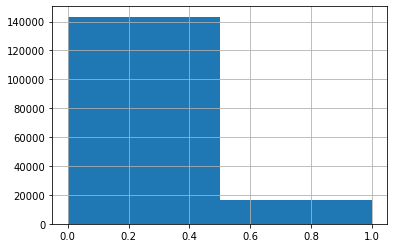

In [6]:
df['toxic'].hist(bins=2)
print('Токсичных комментариев в', round((df['toxic']==0).sum() / (df['toxic']==1).sum(), 2), 'больше, чем нетоксичных')

In [7]:
df = df.drop(['text', 'clean_text'], axis=1)

Мы видим дисбаланс классов

In [8]:
train, test = train_test_split(df, test_size=0.25)
train = train.dropna()


train_features = train.drop('toxic', axis=1)
corpus_train = train_features['lemm_text'].values.astype('U')
train_target = train['toxic']

test_features = test.drop('toxic', axis=1)
corpus_test = test_features['lemm_text'].values.astype('U')
test_target = test['toxic']


print('Размер обучающей выборки:', train.shape)
print('Размер тестовой выборки:', test.shape)

Размер обучающей выборки: (119678, 2)
Размер тестовой выборки: (39893, 2)


## Обучение

### TF-IDF + логистическая регрессия

In [9]:
stopwords = set(nltk_stopwords.words('english'))
count_tf_idf = TfidfVectorizer(stop_words=stopwords)
tf_idf = count_tf_idf.fit_transform(corpus_train)
tf_idf_pred = count_tf_idf.transform(corpus_test)

In [11]:
lr = LogisticRegression()
lr = lr.fit(tf_idf, train_target)
lr_predictions = lr.predict(tf_idf_pred)

In [12]:
print('F1-метрика для TF-IDF + логистическая регрессия:', f1(test_target, lr_predictions))

F1-метрика для TF-IDF + логистическая регрессия: 0.7261815453863465


### LightGBM

## Выводы

array([0.03852622, 0.01763149, 0.91574907, ..., 0.01804539, 0.00282351,
       0.00706991])

## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке исполнения
- [ ]  Данные загружены и подготовлены
- [ ]  Модели обучены
- [ ]  Значение метрики *F1* не меньше 0.75
- [ ]  Выводы написаны